In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# iFood Customer Offer Strategy: An Exploratory Data Analysis

### Introduction

This notebook conducts a deep exploratory data analysis (EDA) on the iFood marketing campaign dataset. The primary goal is to analyze historical data on customers, offers, and transactions to uncover patterns that can inform a more effective and personalized offer distribution strategy. By understanding who our customers are and how they interact with different marketing stimuli, we can build a foundation for a data-driven model that decides which offer to send to each customer, aiming to increase engagement and profitability.

### Executive Summary of Key Insights

Our initial analysis of the customer profiles, transaction events, and offer campaigns has revealed several key insights:

* **Customer Profile**:
    * The customer base is predominantly **male**, though the female segment is also substantial. A notable number of profiles have an "Unknown" gender, highlighting an opportunity for data enrichment.
    * The largest and most engaged customer segment is the **51+ age group**, which is highly active across most metrics. The overall age distribution is skewed towards a more mature audience.
    * The financial profiles of male and female customers, as proxied by credit card limits, are remarkably similar, suggesting that gender alone is not a strong predictor of spending power.

* **Customer Behavior & Engagement**:
    * Standard **transactions are the most frequent event** on the platform, indicating healthy purchasing activity independent of offers.
    * A critical business opportunity lies in the **gap between "offer viewed" and "offer completed" events**. A large number of users see offers but do not convert, and our modeling efforts should focus on closing this gap.
    * Customers who engage with offers ("Uses Offers") exhibit a significantly **higher volume of transactions** overall, confirming that offer engagement is a strong indicator of a valuable customer.

* **Campaign & Channel Performance**:
    * While `email` is the most frequently used marketing channel, the **`web` channel demonstrates the highest conversion rate** (view-to-completion), making it our most efficient channel for driving action.
    * Informational offers appear to be most effective at influencing **higher-value purchases among mature customer segments** (`36-50` and `51+`), suggesting they are a valuable tool for driving revenue from this key demographic.
    * Engagement for all customer segments peaked around weeks 2-3 of the test period before declining, which may indicate initial campaign success followed by potential audience fatigue.

### Methodology

The analysis in this notebook follows a structured approach:
1.  **Data Cleaning and Preparation**: Raw data from the three sources is loaded, cleaned (e.g., handling age outliers and null values), and restructured for analysis.
2.  **Exploratory Data Analysis (EDA)**: A series of univariate and multivariate visualizations are generated to understand distributions, identify relationships between variables, and derive the insights summarized above.
3.  **Technology Stack**: All large-scale data manipulation and aggregation is performed using **PySpark** to ensure scalability. Visualizations are created using the Python libraries **Seaborn** and **Matplotlib**.

### Dataset Overview

Below is a statistical summary of the datasets used in this analysis.

#### `offers.json`
* **Total Unique Offers**: `10`
* **Offer Type Distribution**:
    * BOGO: `4`
    * Discount: `4`
    * Informational: `2`
* **Channels Used**: `email, web, mobile, social`

#### `profile.json`
* **Total Unique Customers**: `~17000`
* **Customer Age Range (Cleaned)**: `18` to `118`
* **Gender Distribution**:
    * F: `~6000`
    * M: `~9000`
    * O: `~2000`
    * Unknown: `200`

#### `transactions.json`
* **Total Events Recorded**: `306,534`
* **Experiment Time Range**: Day `0` to Day `29`
* **Event Type Distribution**:
    * transaction: `~140000`
    * offer received: `~70000`
    * offer viewed: `~54000`
    * offer completed: `~37000`

## Imports

In [23]:
import pyspark
import pyspark.sql.functions as F
from ifood_case.data_visualizer import DataVisualizer
from ifood_case.data_processing import DataProcessing

## Initialize Spark

In [4]:
spark = pyspark.sql.SparkSession.builder.appName("ifood-case").getOrCreate()

25/09/25 18:42:48 WARN Utils: Your hostname, solid resolves to a loopback address: 127.0.0.2; using 192.168.0.39 instead (on interface enp5s0)
25/09/25 18:42:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/25 18:42:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/25 18:42:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load Data 

In [5]:
offers = spark.read.json("../data/raw/offers.json")
transactions = spark.read.json("../data/raw/transactions.json")
profile = spark.read.json("../data/raw/profile.json")

## Data Exploration

In [6]:
data_processing = DataProcessing(offers, transactions, profile)

In [7]:
df_joined, offers, transactions, profile = data_processing.transform()

In [8]:
data_visualizer = DataVisualizer(offers, transactions, profile, df_joined)

In [9]:
offers.show(10,truncate=False)

+----------------------------+--------------+--------+--------------------------------+---------+-------------+
|channels                    |discount_value|duration|id                              |min_value|offer_type   |
+----------------------------+--------------+--------+--------------------------------+---------+-------------+
|[email, mobile, social]     |10            |7.0     |ae264e3637204a6fb9bb56bc8210ddfd|10       |bogo         |
|[web, email, mobile, social]|10            |5.0     |4d5c57ea9a6940dd891ad53e9dbe8da0|10       |bogo         |
|[web, email, mobile]        |0             |4.0     |3f207df678b143eea3cee63160fa8bed|0        |informational|
|[web, email, mobile]        |5             |7.0     |9b98b8c7a33c4b65b9aebfe6a799e6d9|5        |bogo         |
|[web, email]                |5             |10.0    |0b1e1539f2cc45b7b9fa7c272da2e1d7|20       |discount     |
|[web, email, mobile, social]|3             |7.0     |2298d6c36e964ae4a3e7e9706d1fb8c2|7        |discoun

In [11]:
profile.count()

17000

In [13]:
transactions.count()

306534

In [25]:
min_max_values = transactions.agg(
    F.min("time_since_test_start").alias("time_since_test_start_min"),
    F.max("time_since_test_start").alias("time_since_test_start_max")
)

In [27]:
min_max_values.show()

+-------------------------+-------------------------+
|time_since_test_start_min|time_since_test_start_max|
+-------------------------+-------------------------+
|                      0.0|                    29.75|
+-------------------------+-------------------------+



### Univariate Analysis 

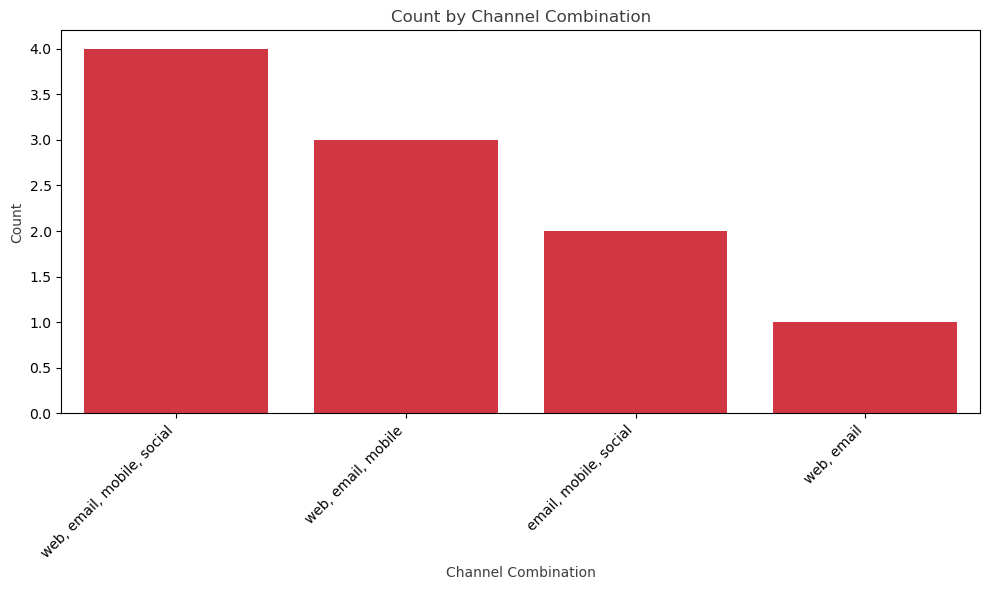

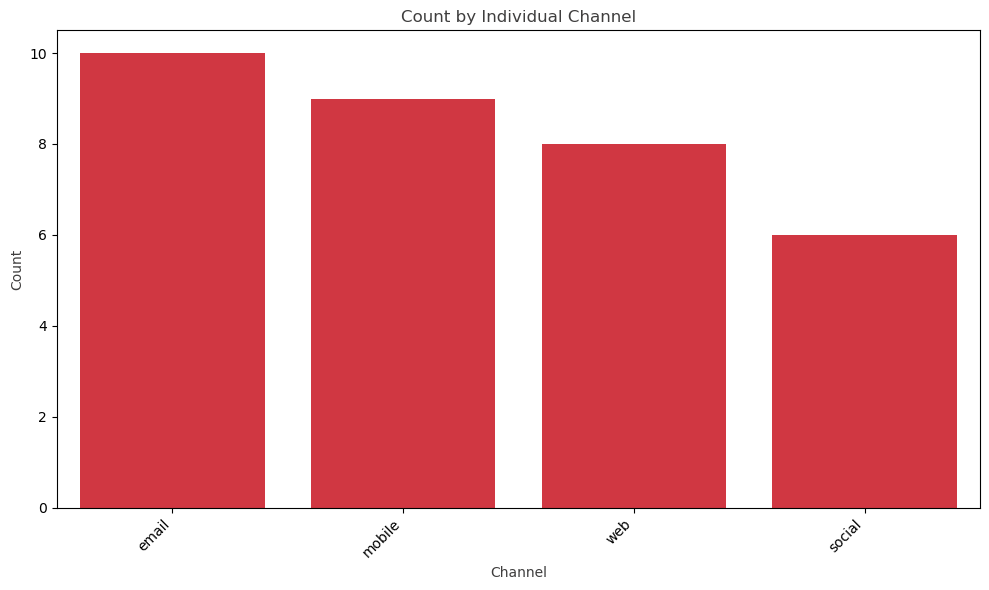

In [9]:
data_visualizer.plot_barplot_channels()

**Key Insight**: 
- The email channel is the most utilized in our campaigns, present in the most frequent combination and also being the most frequently used individual channel. This indicates it is our primary means of communicating offers.

**Multichannel Strategy**:
- The most common channel combination is the one that uses all four (web, email, mobile, social), suggesting a high-reach marketing strategy.

**Business Implication**: 
- Analyzing the conversion rate by channel (which we will do next) will be crucial to understand if the high usage of email and the "all channels" combination translates to greater effectiveness, or if we can optimize our investment by focusing on more specific channels with a higher ROI.

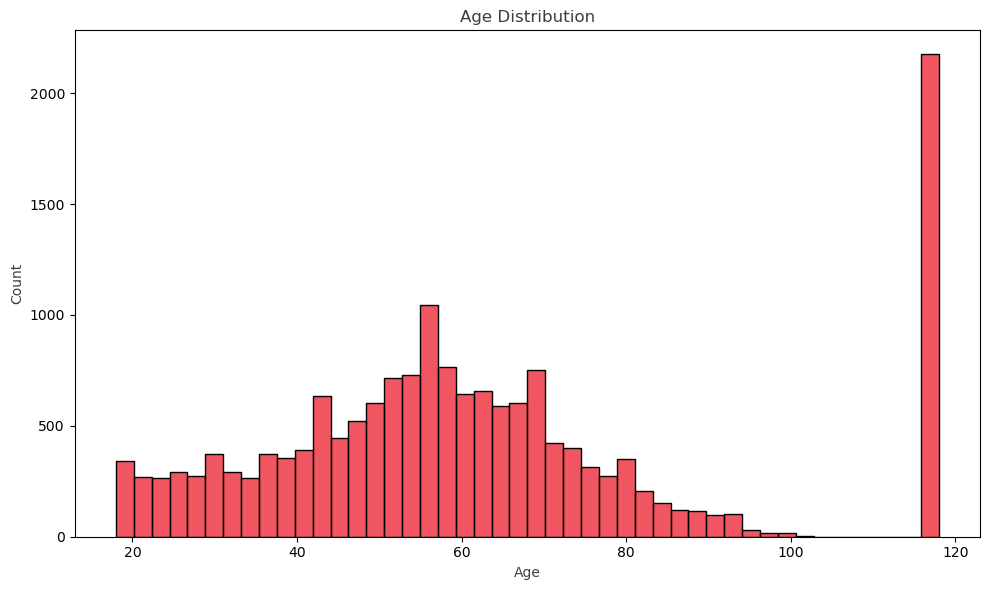

In [10]:
data_visualizer.plot_histogram_age()

**Key Insight**: 
- The highest concentration of customers is in the 50 to 75 age range, with a notable peak around 60 years of age. This suggests that our primary audience is more mature, which may influence the type of offers and the messaging that resonate most with them.

**Point of Attention**: 
- There is an anomalous spike of over 2,000 customers with an age of 118. This is clearly a default value or a data entry error. In our analysis and predictive model, these records have been treated as "age unknown" to avoid distorting the results.

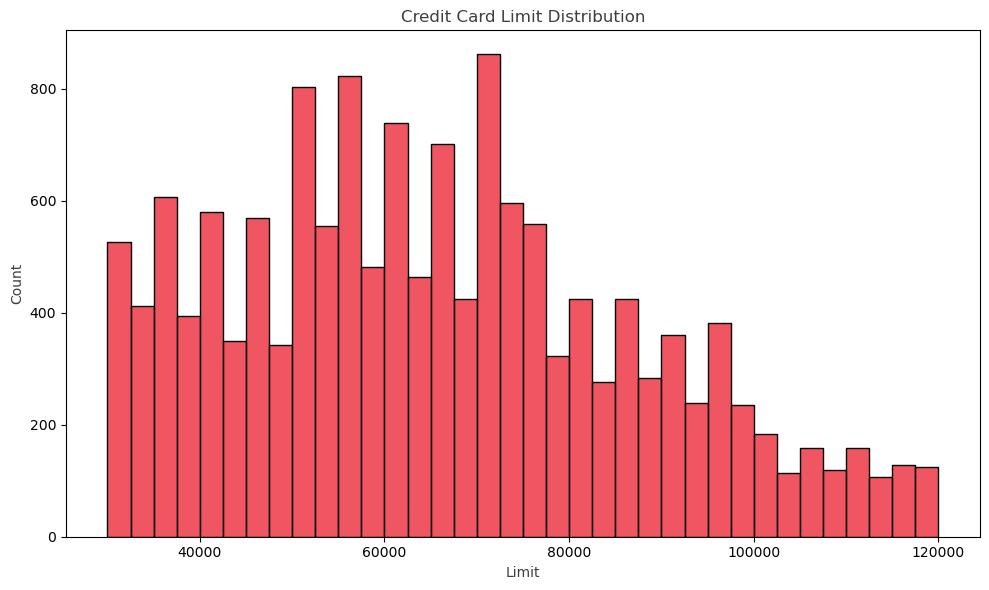

In [11]:
data_visualizer.plot_histogram_credit_card_limit()

**Key Insight**: 
- The distribution of credit limits is quite varied, but we see a higher concentration in the $45,000 to $75,000 range. There isn't a single concentration, indicating that we have customers across various levels of spending power.

**Business Implication**: 
- The absence of a clear financial "cluster" suggests that a "one-size-fits-all" strategy for value-based offers may not be the most effective. Segmenting by credit limit range could be a powerful feature for our model to decide the minimum purchase value for an offer.

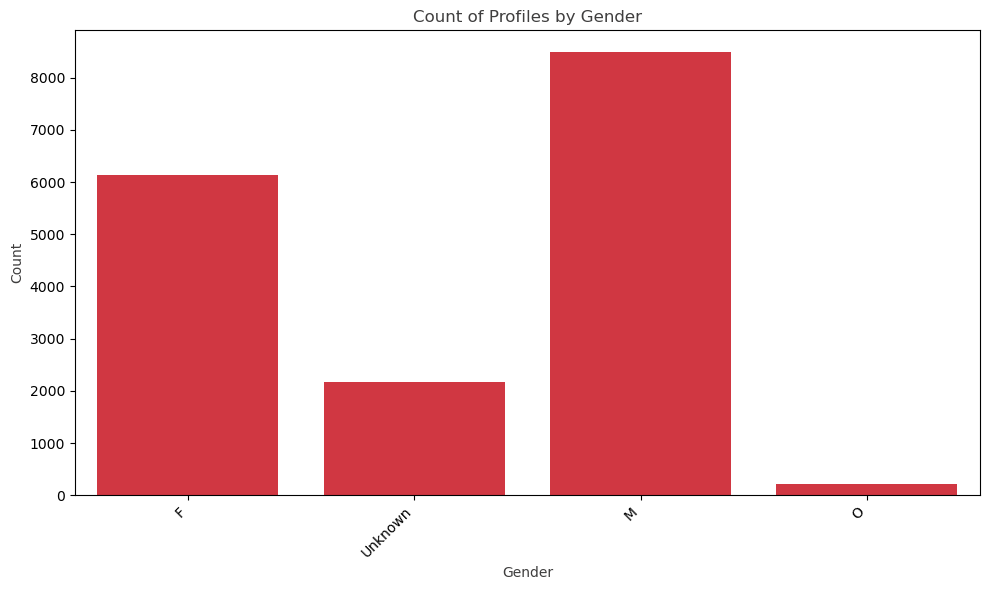

In [12]:
data_visualizer.plot_barplot_gender()


**Key Insight**: 
- The customer base is predominantly male, representing the largest portion of registered profiles. The female segment is also very significant. <br>

**Point of Attention**:
- A significant portion of users (approximately 2,000) did not have their gender provided ("Unknown"). For modeling purposes, we will handle these cases, but for the business, this could indicate an opportunity to enrich the registration process in the future to allow for even more precise personalization. The "Other" (O) group is currently too small to generate statistically relevant analyses, but its growth should be monitored.

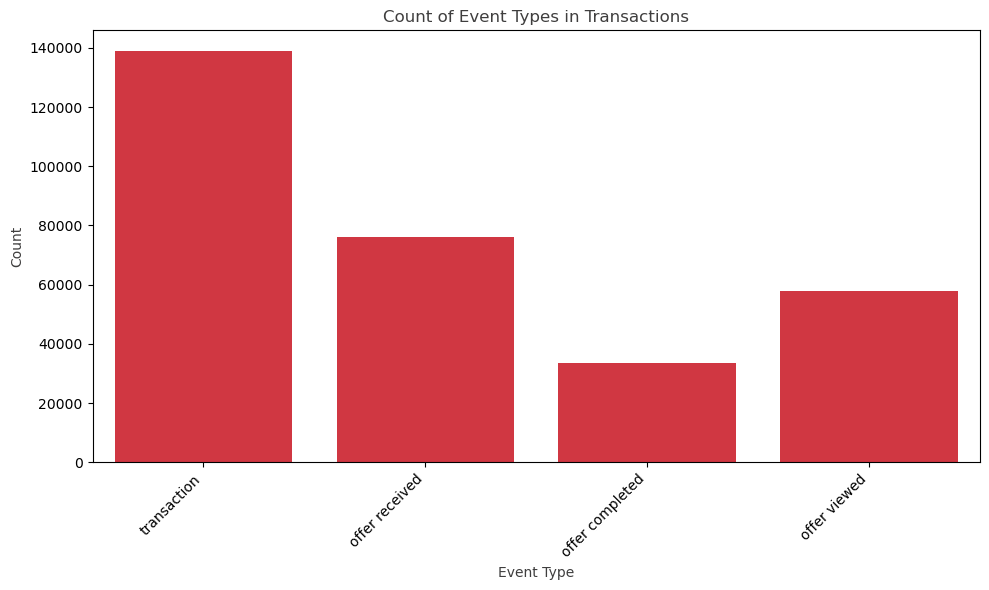

In [13]:
data_visualizer.plot_barplot_event()

**Key Insight**: 
- The most common event is a pure "transaction", with nearly 140,000 occurrences. This is positive, as it indicates that the primary activity on the platform is purchasing.

**Offer Funnel Analysis**:

- Received: We see a large number of offers being sent (~76,000).

- Viewed vs. Completed: The number of offers viewed (\~58,000) is significantly higher than the number of offers completed (\~34,000). This reveals the key challenge and opportunity: we have a large number of customers who see the offers but do not use them.

### Bivariate Analysis 

/home/felipemarcelino/Projects/ifood-case/src/ifood_case/data_visualizer.py:203: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.histplot(


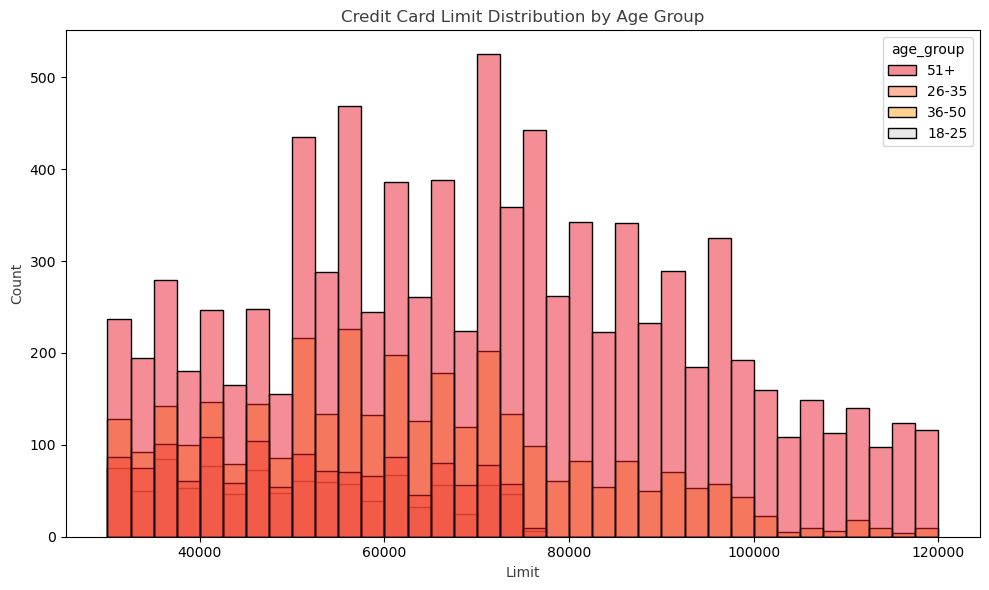

In [14]:
data_visualizer.plot_histogram_age_credit_card_limit()

**Key Insight**: 
- The 51+ age group represents the largest portion of customers across nearly all credit limit tiers, which is consistent with our earlier finding that they are the largest demographic segment. Critically, the overall shape of the credit limit distribution is very similar across all age groups. We do not observe a pattern where older customers are significantly more concentrated in the higher-limit tiers compared to younger segments.

**Business Implication**: 
- This suggests that age by itself is not a strong predictor of a customer's spending power (as proxied by their credit limit). A simple strategy like "target high-value offers at older customers" would be ineffective, as there are customers with high credit limits across all age brackets. Our model will need to rely on a combination of features, rather than simple demographic rules, to effectively identify high-value customers

/home/felipemarcelino/Projects/ifood-case/src/ifood_case/data_visualizer.py:230: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.histplot(


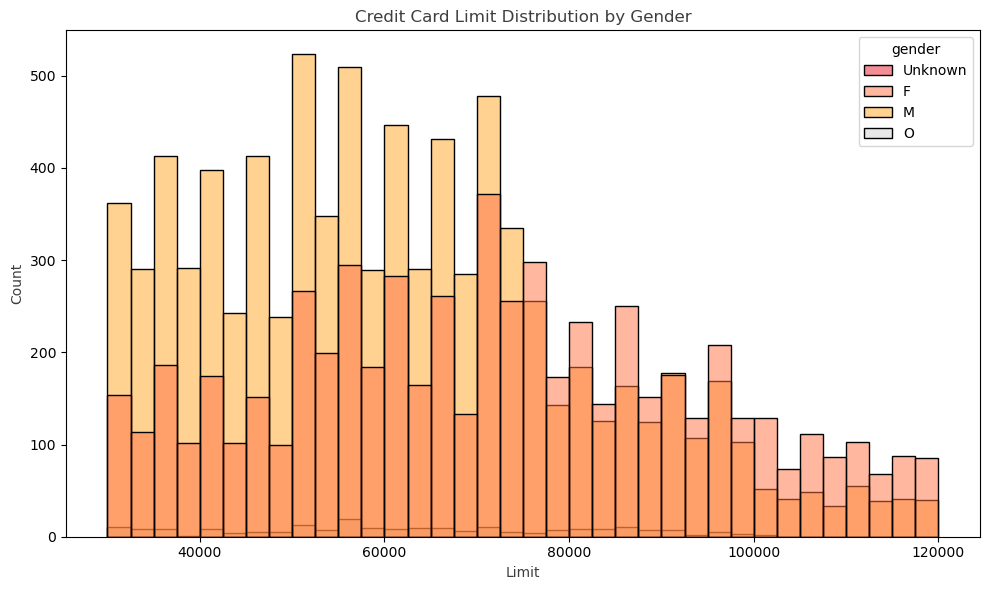

In [15]:
data_visualizer.plot_histogram_gender_credit_card_limit()

**Key Insight**: 
- While our customer base has more users identified as male than female, the distribution of their credit card limits is remarkably similar. Both male and female segments follow the same pattern of concentration in the \\$45k-\\$75k range and a gradual tailing off at higher limits. There is no clear visual evidence to suggest that one gender has significantly higher spending power than another.

**Business Implication**: 
- This is a valuable finding because it helps to debunk a common assumption. A strategy based solely on gender to determine offer value would likely be inefficient. The model should learn to find value in customers irrespective of their gender, focusing instead on their transactional behaviors and individual financial profiles. The "Unknown" gender category also follows this same distribution, suggesting they are not a distinct financial segment but rather a mix of users.

### Multivariate Analysis 

/home/felipemarcelino/Projects/ifood-case/src/ifood_case/data_visualizer.py:264: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


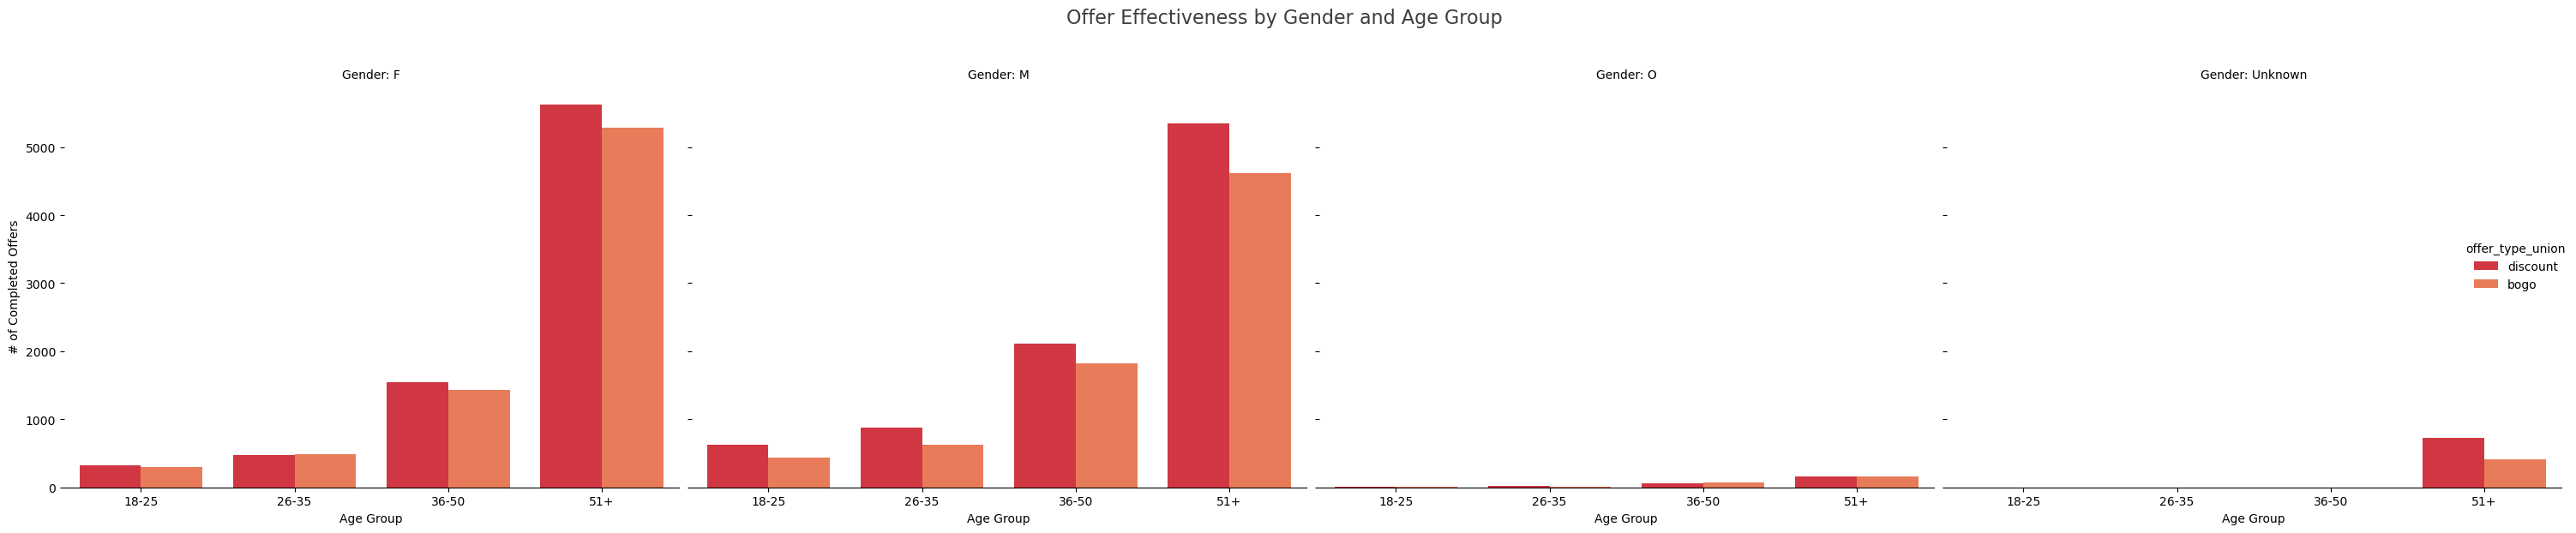

In [16]:
data_visualizer.plot_offer_effectiveness_by_profile()

**Key Insight**: 
- Both male and female customers show a very similar pattern of offer completion: the 51+ age group is by far the most active, followed by the 36-50 group. Across all segments, "discount" and "BOGO" (Buy One, Get One) offers are completed at nearly identical rates, with discounts having a slight edge.

**Business Implication**: 
- Since the preference for BOGO vs. Discount offers is not strongly differentiated by age or gender, our model will need to rely on more nuanced behavioral features (like past transaction history) to make a personalized choice between these two offer types. The "Unknown" gender group also shows significant activity, reinforcing the need for a model that can make decisions even with incomplete demographic data.

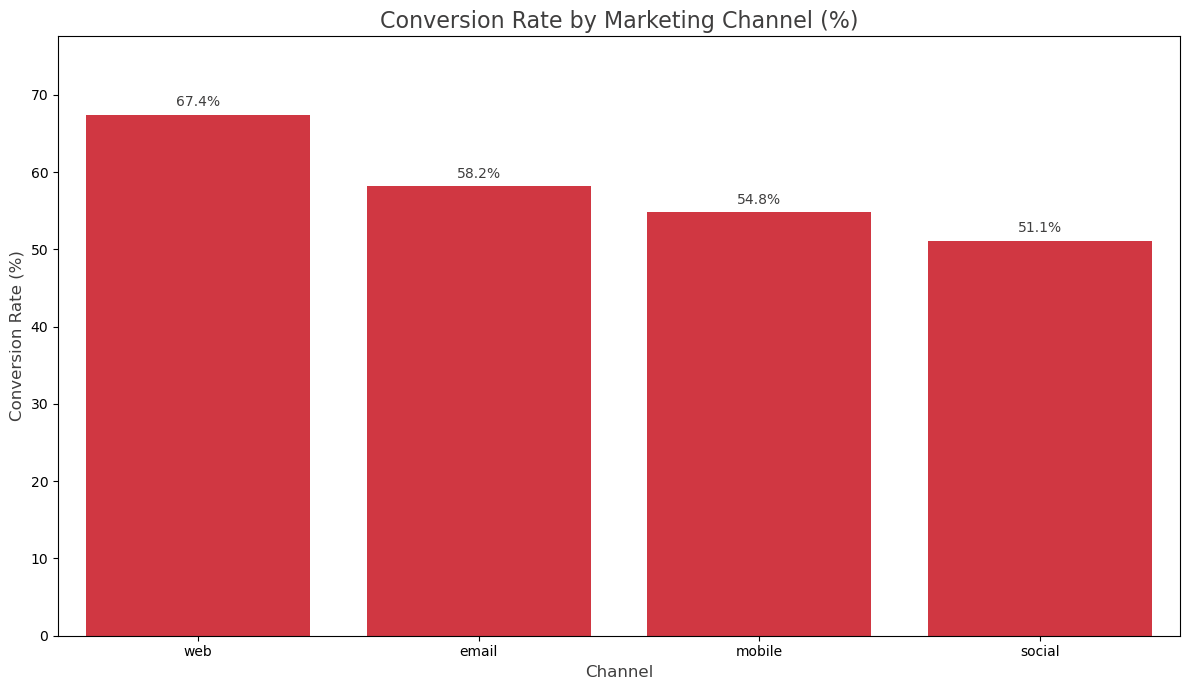

In [17]:
data_visualizer.plot_conversion_rate_by_channel()

**Key Insight**: 
- The web channel is the most effective at converting a viewed offer into a completed offer, boasting a 67.4% conversion rate. Email and mobile are also strong performers, with rates of 58.2% and 54.8% respectively. The social channel has the lowest conversion rate at 51.1%.

**Business Implication**: 
- While the email channel may have the highest volume (as seen in the earlier analysis), the web interface is the most efficient conversion tool. This suggests that optimizing the user experience on the web and ensuring offers are prominently displayed there could yield the highest return on investment. The lower performance of the social channel might warrant a review of our strategy for that platform.

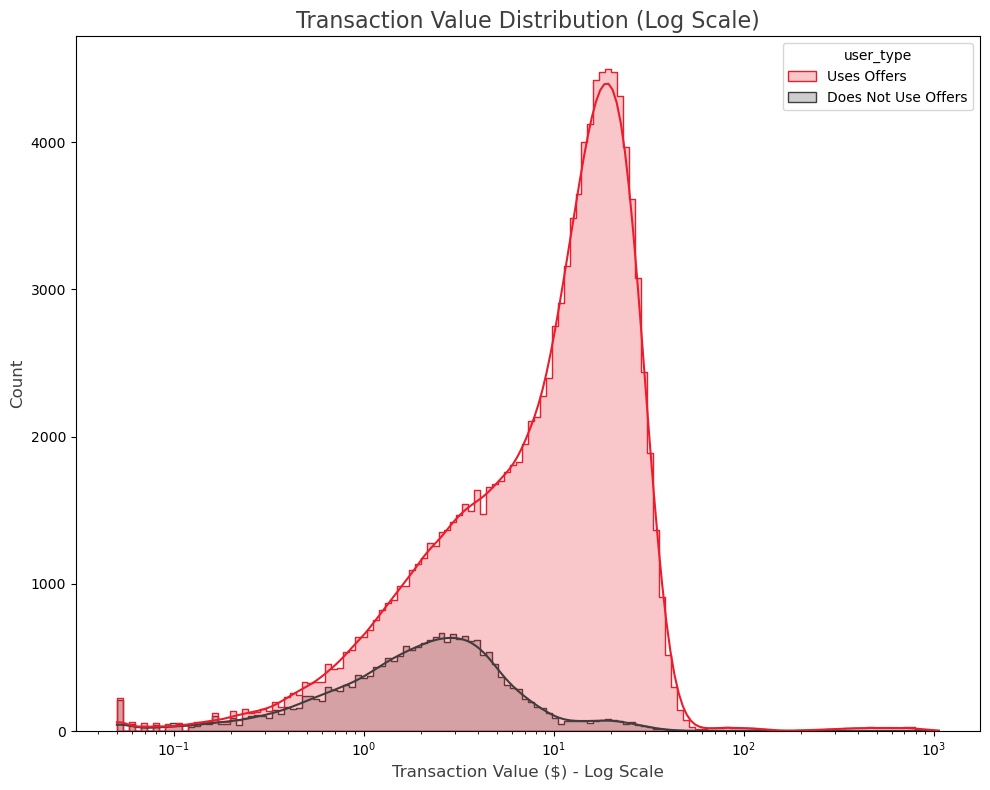

In [18]:
data_visualizer.plot_transaction_value_by_offer_usage()

**Key Insight**: 
- This log-scale histogram clearly shows that the group of customers who use offers ("Uses Offers") make significantly more transactions across all value tiers compared to those who do not. The shape of the distribution is similar for both groups, indicating that offer users are not just making high-value purchases, but are more active shoppers overall.

**Business Implication**: 
- This is a critical finding that validates the offer strategy. Offers are not just providing discounts; they are correlated with a higher overall transaction volume. Customers who engage with offers are our most active buyers. The model's goal should be to encourage more customers to move into this "Uses Offers" category, thereby increasing their overall engagement and value to the platform.

/home/felipemarcelino/Projects/ifood-case/src/ifood_case/data_visualizer.py:474: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.catplot(


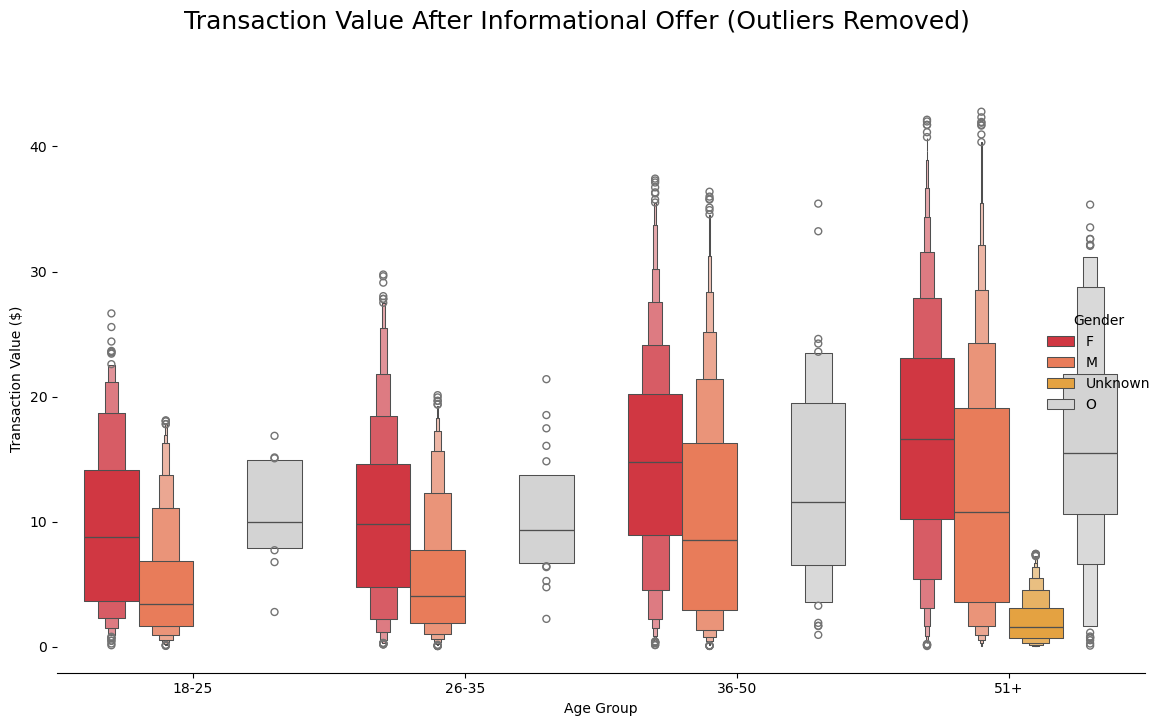

In [19]:
data_visualizer.plot_informational_offer_impact()

**Key Insight**: 
- Among customers who make a purchase after viewing an informational offer, the median transaction value is highest and most consistent for the 36-50 and 51+ age groups. Younger segments (18-25, 26-35) not only transact less after viewing these offers but also tend to spend less when they do.

**Business Implication**: 
- Informational offers appear to be most effective at influencing higher-value purchases among our more mature customer segments. This suggests that content-driven, informational campaigns could be a powerful tool to drive significant revenue from these specific demographics, while a different strategy (e.g., direct discounts) might be needed to activate younger users.

Starting temporal engagement analysis by profile...


/home/felipemarcelino/Projects/ifood-case/src/ifood_case/data_visualizer.py:533: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(


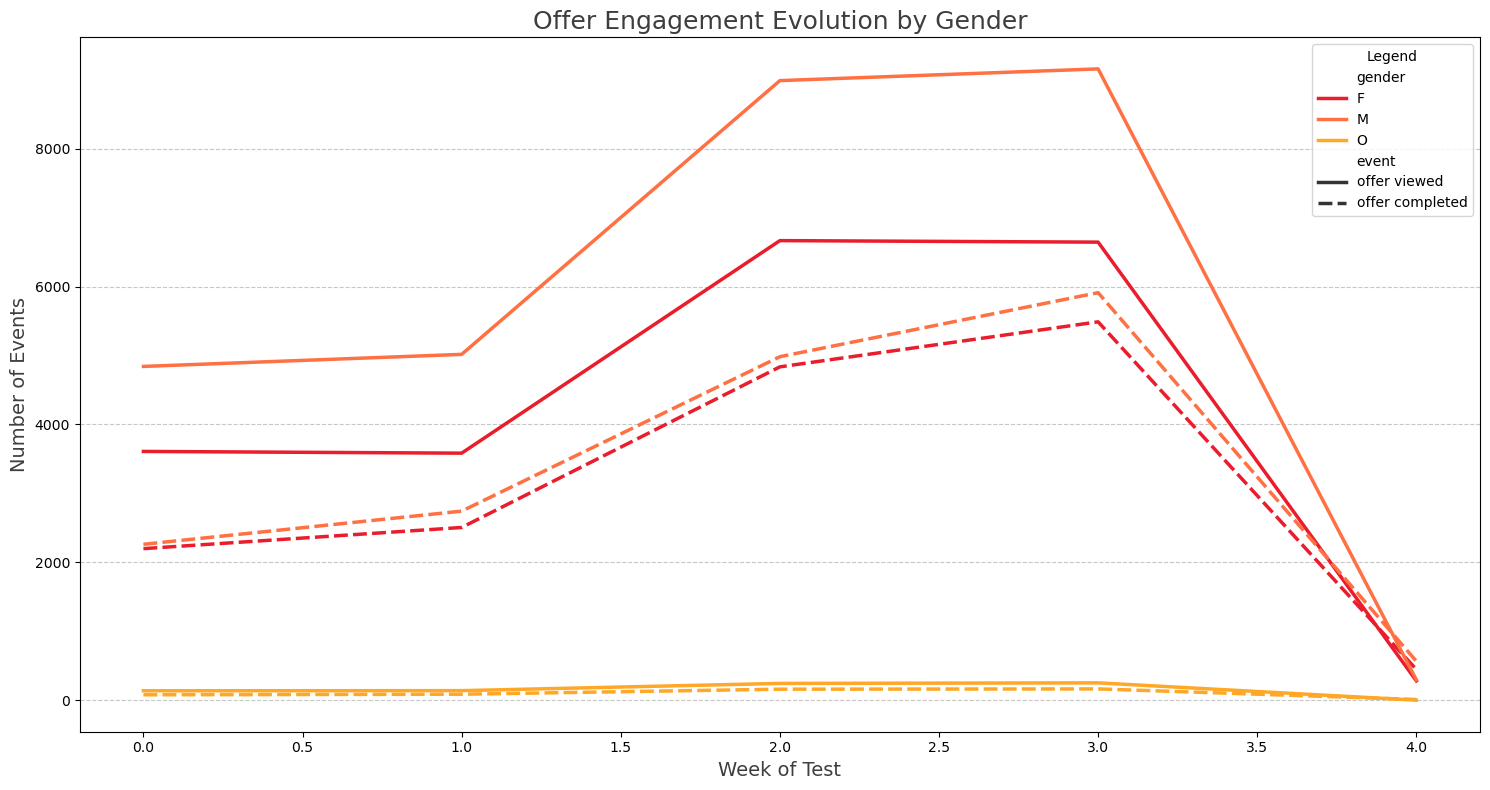

/home/felipemarcelino/Projects/ifood-case/src/ifood_case/data_visualizer.py:551: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(


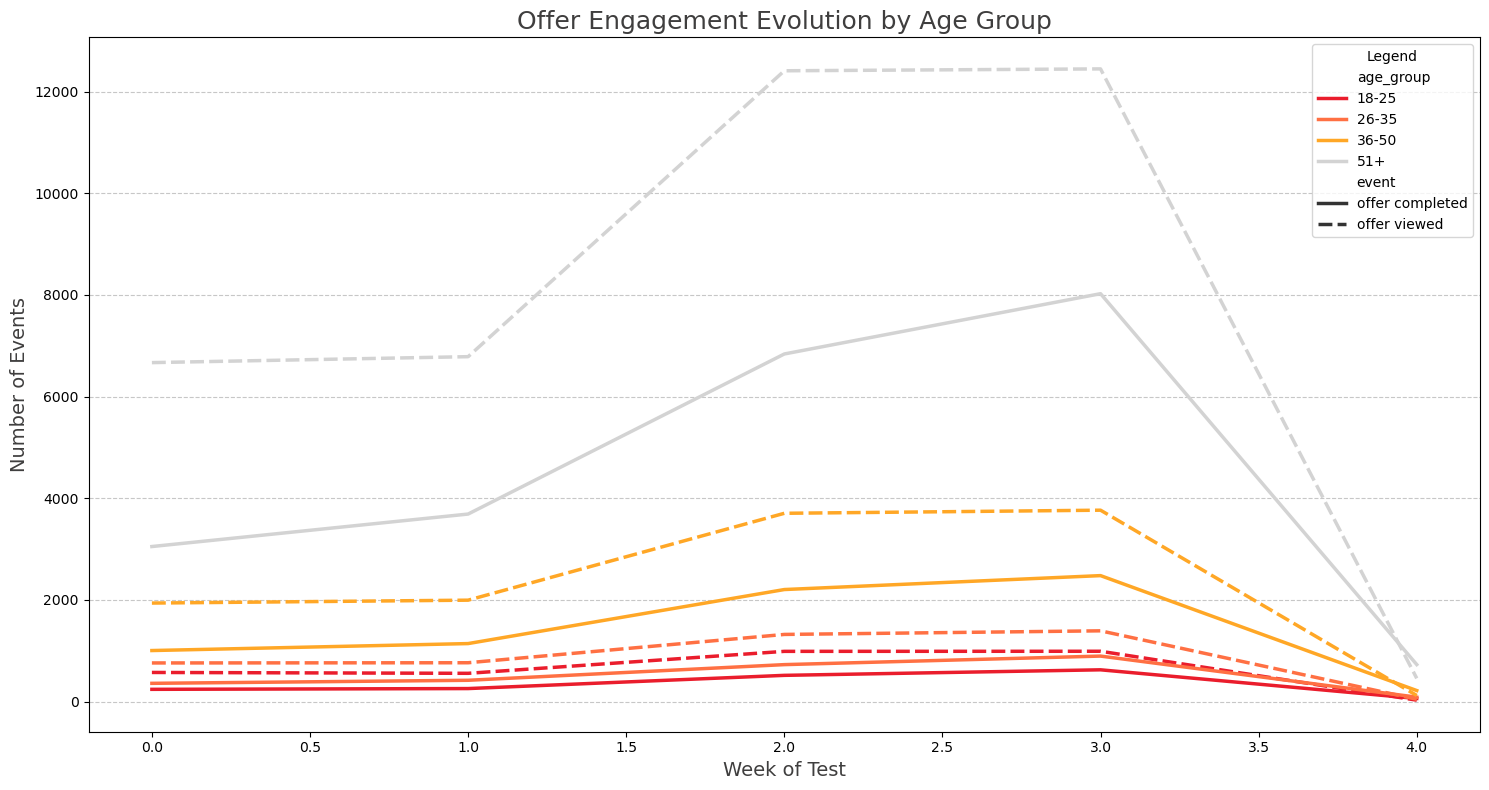

In [20]:
data_visualizer.plot_engagement_over_time_by_profile()

**Key Insight**: 
- The 51+ age group (light grey lines) dominates the engagement volume, showing a massive peak in offers viewed and completed around weeks 2 and 3 of the test. Other age groups show much lower, but relatively stable, engagement throughout the period. A sharp drop-off in activity is visible for all groups after week 3.
- Similar to the age group chart, both male and female customers show a significant peak in engagement between weeks 1 and 3, followed by a sharp decline. Throughout the peak, male customers (orange lines) consistently viewed and completed more offers than female customers (red lines), which is expected as they represent a larger portion of the user base.

**Business Implication**: 
- The peak activity in weeks 2-3 suggests a successful campaign launch, particularly with the 51+ segment. The sharp decline across all groups after week 3 could indicate campaign fatigue or the end of the test period. Future strategies should explore how to sustain engagement over a longer duration or introduce new stimuli after the initial peak.
- The engagement trend is consistent across genders, reinforcing that the campaign's timing and lifecycle had a universal effect. The gap between "viewed" (dashed lines) and "completed" (solid lines) is substantial for both groups, highlighting the key opportunity for the model: to effectively convert engaged viewers into active users, regardless of gender.

### Saving

In [21]:
offers.write.mode("overwrite").parquet("../data/processed/offers_processed")
transactions.write.mode("overwrite").parquet("../data/processed/transactions_processed")
profile.write.mode("overwrite").parquet("../data/processed/profile_processed")